In [11]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



# FEATURE ENGINEERING - SENTIMENT ANALYSIS

In [3]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.sql.functions import length
import pyspark.sql.functions as F

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [28]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

3.4.0


## DATA CLEANING

In [4]:
%%time
bucket = "project-group34"
session = sagemaker.Session()
output_prefix_data_submissions = "project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://project-group34/project/submissions/yyyy=*


23/11/30 19:37:01 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


CPU times: user 162 ms, sys: 26.6 ms, total: 188 ms
Wall time: 6.89 s


23/11/30 19:37:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# Assuming your DataFrame is named `df`
submissions = submissions.withColumn('post_length', length(submissions.title) + length(submissions.selftext))

In [6]:
from pyspark.sql import functions as F

submissions = submissions.withColumn('created_utc', F.to_timestamp('created_utc'))

# Extract time-based features
submissions = submissions.withColumn('hour_of_day', F.hour('created_utc'))
submissions = submissions.withColumn('day_of_week', F.dayofweek('created_utc'))  # 1 (Sunday) to 7 (Saturday)
# Map each day of the week from numeric to string
submissions = submissions.withColumn('day_of_week_str', F.expr("""
    CASE day_of_week 
        WHEN 1 THEN 'Sunday'
        WHEN 2 THEN 'Monday'
        WHEN 3 THEN 'Tuesday'
        WHEN 4 THEN 'Wednesday'
        WHEN 5 THEN 'Thursday'
        WHEN 6 THEN 'Friday'
        WHEN 7 THEN 'Saturday'
    END
"""))
submissions = submissions.withColumn('day_of_month', F.dayofmonth('created_utc'))
submissions = submissions.withColumn('month', F.month('created_utc'))
submissions = submissions.withColumn('year', F.year('created_utc'))

submissions = submissions.withColumn('has_media', F.col('media').isNotNull())

In [7]:
submissions = submissions.drop(*["media"])

In [8]:
submissions = submissions.select('subreddit',
                                 'title',
                                 'selftext',
                                 'score',
                                 'num_comments',
                                 'over_18',
                                 'is_self',
                                 'is_video',
                                 'domain',
                                 'post_length',
                                 'hour_of_day',
                                 'day_of_week',
                                 'day_of_week_str',
                                 'day_of_month',
                                 'month',
                                 'year',
                                 'has_media')

In [9]:
# Combine 'title' and 'selftext' into a new column 'body'
submissions = submissions.withColumn("body", concat_ws(" ", col("title"), col("selftext")))


In [10]:
submissions = submissions.drop(*["title", "selftext"])

In [11]:
submissions.show(5)

+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+
| subreddit|score|num_comments|over_18|is_self|is_video|         domain|post_length|hour_of_day|day_of_week|day_of_week_str|day_of_month|month|year|has_media|                body|
+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+
|television|    0|           9|  false|   true|   false|self.television|        605|         22|          4|      Wednesday|          27|    1|2021|    false|Is there a websit...|
|     anime|    0|           3|  false|  false|   false|      i.redd.it|         50|         22|          4|      Wednesday|          27|    1|2021|    false|Does anyone know ...|
|television|    4|          11|  false|  false|   false|   deadline.com|         86|         22|    

## NLP DATA CLEANING PIPELINE

In [19]:
# Create a DocumentAssembler to convert text into documents
documentAssembler = DocumentAssembler() \
    .setInputCol("body") \
    .setOutputCol("document")

# Tokenize the document
tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# Normalize and set case insensitive to be true
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# Lemmatize
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma')

# Define a list of punctuation symbols to remove
punctuation_symbols = ["!", "\"", "#", "$", "%", "&", "'", "(", ")", "*", "+", ",", "-", ".", "/", ":", ";", "<", "=", ">", "?", "@", "[", "\\", "]", "^", "_", "`", "{", "|", "}", "~"]

# Remove punctuation using StopWordsCleaner
punctuation_remover = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('cleaned_lemma') \
    .setStopWords(punctuation_symbols)

# Finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['cleaned_lemma']) \
    .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [20]:
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           normalizer,
           lemmatizer,
           punctuation_remover,
           finisher
     ])

In [21]:
pipelineModel = pipeline.fit(submissions)
result = pipelineModel.transform(submissions)

In [25]:
result = result.withColumn("final_text", F.concat_ws(" ", "finished_cleaned_lemma"))

In [27]:
result.show(5)

+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
| subreddit|score|num_comments|over_18|is_self|is_video|         domain|post_length|hour_of_day|day_of_week|day_of_week_str|day_of_month|month|year|has_media|                body|            document|               token|          normalized|               lemma|       cleaned_lemma|finished_cleaned_lemma|          final_text|
+----------+-----+------------+-------+-------+--------+---------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+
|television| 

In [28]:
result.write.parquet("s3a://project-group34/project/submissions/sentiment_analysis/")

## SENTIMENT MODEL

### SPARK JOB

In [12]:
%%writefile ./code/ml_sentiment_submissions.py

import os
import logging
import argparse

# Import pyspark and build Spark session
from pyspark.sql.functions import *
from pyspark.sql.types import (
    DoubleType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType
import re
from pyspark.sql.functions import explode, count
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml import Pipeline

from pyspark.sql.functions import desc

import nltk
nltk.download('stopwords')
eng_stopwords = nltk.corpus.stopwords.words('english')

logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")    
    args = parser.parse_args()

    spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
    
    logger.info(f"Spark version: {spark.version}")
    logger.info(f"sparknlp version: {sparknlp.version()}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    df = spark.read.parquet(args.s3_dataset_path, header=True)

    documentAssembler = DocumentAssembler()\
        .setInputCol("final_text")\
        .setOutputCol("document")

    # Paths to the models
    # tfhub_use_path = "../../../cache_pretrained/tfhub_use_en_2.4.0_2.4_1587136330099/"
    # sentimentdl_use_twitter_path = "../../../cache_pretrained/sentimentdl_use_twitter_en_2.7.1_2.4_1610983524713/"
    # sentiment_emotion = "../../../cache_pretrained/cache_pretrained/classifierdl_use_emotion_en_2.7.1_2.4_1610190563302/"

    # Load models from local path
    use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
             .setInputCols(["document"])\
             .setOutputCol("sentence_embeddings")

    sentimentdl = SentimentDLModel.pretrained(name="sentimentdl_use_twitter", lang="en")\
                     .setInputCols(["sentence_embeddings"])\
                     .setOutputCol("sentiment")

    # sentimentdl1 = ClassifierDLModel.load(sentiment_emotion)\
    #     .setInputCols(["sentence_embeddings"])\
    #     .setOutputCol("sentiment_emotion")

    nlpPipeline = Pipeline(
          stages = [
              documentAssembler,
              use,
              sentimentdl
              #sentimentdl1
          ])

    # Apply the pipeline to your DataFrame
    model = nlpPipeline.fit(df)
    result = model.transform(df)
    
    result.write.parquet("s3a://project-group34/project/submissions/sentiment_extracted/", mode="overwrite")
    
    logger.info(f"all done...")
    
if __name__ == "__main__":
    main()

Overwriting ./code/ml_sentiment_submissions.py


In [13]:
%%time
import boto3
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

account_id = boto3.client('sts').get_caller_identity()['Account']

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 33.6 ms


In [14]:
account_id

'655678691473'

In [15]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    image_uri=f"{account_id}.dkr.ecr.us-east-1.amazonaws.com/sagemaker-spark:latest",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=7200,
)

# # S3 URI of the initialization script
# s3_uri_init_script = f's3://{bucket}/{script_key}'

# s3 paths
session = sagemaker.Session()
output_prefix_logs = f"spark_logs"

configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 244 ms


In [16]:
%%time
bucket = "project-group34"
output_prefix_data_comments = "project/submissions/sentiment_analysis/"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/ml_sentiment_submissions.py",
    submit_jars=[f"s3://{bucket}/spark-nlp-assembly-5.1.3.jar"],
    arguments=[
        "--s3_dataset_path",
        s3_path,
    ],
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)
# give some time for resources from this iterations to get cleaned up
# if we start the job immediately we could get insufficient resources error
time.sleep(60)

INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-11-29-01-51-36-228


.............................................................................................................................................................!CPU times: user 620 ms, sys: 48.3 ms, total: 669 ms
Wall time: 14min 16s


### SENTIMENT MODEL PROCESSING

In [59]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)
import pyspark.sql.functions as F

In [60]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

3.4.0


In [48]:
result = spark.read.parquet("s3a://project-group34/project/submissions/sentiment_extracted/")

In [43]:
result.show(5)

+---------+-----+------------+-------+-------+--------+------------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+
|subreddit|score|num_comments|over_18|is_self|is_video|            domain|post_length|hour_of_day|day_of_week|day_of_week_str|day_of_month|month|year|has_media|                body|            document|               token|          normalized|               lemma|       cleaned_lemma|finished_cleaned_lemma|          final_text| sentence_embeddings|           sentiment|
+---------+-----+------------+-------+-------+--------+------------------+-----------+-----------+-----------+---------------+------------+-----+----+---------+--------------------+--------------------+--------------------+--------------------+----------

In [61]:
result.select("sentiment").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------+
|sentiment                                                                                         |
+--------------------------------------------------------------------------------------------------+
|[{category, 0, 56, negative, {sentence -> 0, positive -> 0.09468776, negative -> 0.90531224}, []}]|
|[{category, 0, 49, positive, {sentence -> 0, positive -> 0.890747, negative -> 0.10925303}, []}]  |
|[{category, 0, 39, negative, {sentence -> 0, positive -> 4.9209936E-21, negative -> 1.0}, []}]    |
|[{category, 0, 39, negative, {sentence -> 0, positive -> 4.9209936E-21, negative -> 1.0}, []}]    |
|[{category, 0, 49, negative, {sentence -> 0, positive -> 0.06990129, negative -> 0.9300988}, []}] |
+--------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [65]:
result1 = result.select(
    F.expr("sentiment[0].metadata['positive']").cast("float").alias("positive_score"),
    col("subreddit"),
    col("final_text").alias("text"),
    col("score"),
    col("num_comments"),
    col("over_18"),
    col("is_self"),
    col("is_video"),
    col("post_length"),
    col("hour_of_day"),
    col("day_of_week"),
    col("day_of_month"),
    col("month"),
    col("year"),
    col("has_media")
)

In [66]:
result1.show(5)

+--------------+---------+--------------------+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
|positive_score|subreddit|                text|score|num_comments|over_18|is_self|is_video|post_length|hour_of_day|day_of_week|day_of_month|month|year|has_media|
+--------------+---------+--------------------+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
|    0.09468776|    anime|rumor one punch m...|    0|           2|  false|   true|   false|         62|          3|          4|           7|   12|2022|    false|
|      0.890747|    anime|rumor one punch m...|    2|           2|  false|  false|   false|         53|          3|          4|           7|   12|2022|     true|
| 4.9209936E-21|    anime|can mappa become ...|    1|           1|  false|   true|   false|         46|          3|          4|           7|   12|2022|    false|
| 4.9209936E-21|    anime|ca

In [67]:
result1.write.parquet("s3a://project-group34/project/submissions/sentiment_submissions/", mode="overwrite")

## EMOTION MODEL

### SPARK JOB

In [68]:
%%writefile ./code/ml_emotion_submissions.py

import os
import logging
import argparse

# Import pyspark and build Spark session
from pyspark.sql.functions import *
from pyspark.sql.types import (
    DoubleType,
    IntegerType,
    StringType,
    StructField,
    StructType,
)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType
import re
from pyspark.sql.functions import explode, count
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml import Pipeline

from pyspark.sql.functions import desc

import nltk
nltk.download('stopwords')
eng_stopwords = nltk.corpus.stopwords.words('english')

logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")    
    args = parser.parse_args()

    spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
    
    logger.info(f"Spark version: {spark.version}")
    logger.info(f"sparknlp version: {sparknlp.version()}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    df = spark.read.parquet(args.s3_dataset_path, header=True)

    documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

    # Paths to the models
    # tfhub_use_path = "../../../cache_pretrained/tfhub_use_en_2.4.0_2.4_1587136330099/"
    # sentimentdl_use_twitter_path = "../../../cache_pretrained/sentimentdl_use_twitter_en_2.7.1_2.4_1610983524713/"
    # sentiment_emotion = "../../../cache_pretrained/cache_pretrained/classifierdl_use_emotion_en_2.7.1_2.4_1610190563302/"

    # Load models from local path
    use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
             .setInputCols(["document"])\
             .setOutputCol("sentence_embeddings")

    # sentimentdl = SentimentDLModel.pretrained(name="sentimentdl_use_twitter", lang="en")\
    #                  .setInputCols(["sentence_embeddings"])\
    #                  .setOutputCol("sentiment")

    sentimentdl1 = ClassifierDLModel.pretrained(name="classifierdl_use_emotion")\
        .setInputCols(["sentence_embeddings"])\
        .setOutputCol("sentiment_emotion")

    nlpPipeline = Pipeline(
          stages = [
              documentAssembler,
              use,
              sentimentdl1
              #sentimentdl
          ])

    # Apply the pipeline to your DataFrame
    model = nlpPipeline.fit(df)
    result = model.transform(df)
    
    result.write.parquet("s3a://project-group34/project/submissions/emotion_extracted/", mode="overwrite")
    
    logger.info(f"all done...")
    
if __name__ == "__main__":
    main()

Overwriting ./code/ml_emotion_submissions.py


In [69]:
%%time
import boto3
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

account_id = boto3.client('sts').get_caller_identity()['Account']

CPU times: user 16.7 ms, sys: 618 µs, total: 17.3 ms
Wall time: 35 ms


In [70]:
account_id

'655678691473'

In [71]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    image_uri=f"{account_id}.dkr.ecr.us-east-1.amazonaws.com/sagemaker-spark:latest",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=7200,
)

# # S3 URI of the initialization script
# s3_uri_init_script = f's3://{bucket}/{script_key}'

# s3 paths
session = sagemaker.Session()
output_prefix_logs = f"spark_logs"

configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 74.2 ms, sys: 3.44 ms, total: 77.7 ms
Wall time: 124 ms


In [72]:
%%time
bucket = "project-group34"
output_prefix_data_comments = "project/submissions/sentiment_submissions/"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/ml_emotion_submissions.py",
    submit_jars=[f"s3://{bucket}/spark-nlp-assembly-5.1.3.jar"],
    arguments=[
        "--s3_dataset_path",
        s3_path,
    ],
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)
# give some time for resources from this iterations to get cleaned up
# if we start the job immediately we could get insufficient resources error
time.sleep(60)

INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-11-29-03-06-29-254


......................................................................................................................................................!CPU times: user 681 ms, sys: 60.6 ms, total: 742 ms
Wall time: 13min 41s


### EMOTION MODEL PROCESSING

In [2]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)
import pyspark.sql.functions as F

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

3.4.0


In [5]:
result = spark.read.parquet("s3a://project-group34/project/submissions/emotion_extracted/")

23/11/29 03:21:34 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [6]:
result.show(5)

+--------------+----------+--------------------+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+--------------------+--------------------+--------------------+
|positive_score| subreddit|                text|score|num_comments|over_18|is_self|is_video|post_length|hour_of_day|day_of_week|day_of_month|month|year|has_media|            document| sentence_embeddings|   sentiment_emotion|
+--------------+----------+--------------------+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+--------------------+--------------------+--------------------+
|           1.0|    movies|sidney poitier a ...|17101|         501|  false|  false|   false|         53|         16|          7|          20|    2|2021|    false|[{document, 0, 48...|[{sentence_embedd...|[{category, 0, 48...|
|     0.5907684|     anime|help i get into a...|    0|          13|  false|   true|   false|    

In [7]:
result.printSchema()

root
 |-- positive_score: float (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- text: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- post_length: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- has_media: boolean (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = true)
 |    |    |-- end: integer (nullable = true)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-

In [11]:
result.select("sentiment_emotion").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment_emotion                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------+
|[{category, 0, 48, surprise, {surprise -> 0.94696283, joy -> 0.0021084917, fear -> 0.048108246, sadness -> 0.0028204152, sentence -> 0}, []}]|
|[{category, 0, 58, sadness, {surprise -> 9.781701E-8, joy -> 1.0658228E-8, fear -> 5.8513685E-8, sadness -> 0.9999999, sentence -> 0}, []}]  |
|[{category, 0, 109, fear, {surprise -> 1.6646996E-9, joy -> 2.359295E-10, fear -> 1.0, sadness -> 4.3215704E-12, sentence -> 0}, []}]        |
|[{category, 0, 43, joy, {surprise -> 0.005493851, joy -> 0.95643336, fear -> 0.0028001422, sadness -> 0.035272676, sentence -> 0}, []}]

In [12]:
result1 = result.select(
    F.expr("sentiment_emotion[0].result").alias("emotion"),
    col("positive_score").alias("sentiment_score"),
    col("subreddit"),
    col("text"),
    col("score"),
    col("num_comments"),
    col("over_18"),
    col("is_self"),
    col("is_video"),
    col("post_length"),
    col("hour_of_day"),
    col("day_of_week"),
    col("day_of_month"),
    col("month"),
    col("year"),
    col("has_media")
)

In [13]:
result1.show(5)

+--------+---------------+----------+--------------------+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
| emotion|sentiment_score| subreddit|                text|score|num_comments|over_18|is_self|is_video|post_length|hour_of_day|day_of_week|day_of_month|month|year|has_media|
+--------+---------------+----------+--------------------+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
|surprise|            1.0|    movies|sidney poitier a ...|17101|         501|  false|  false|   false|         53|         16|          7|          20|    2|2021|    false|
| sadness|      0.5907684|     anime|help i get into a...|    0|          13|  false|   true|   false|         63|         16|          7|          20|    2|2021|    false|
|    fear|      0.9160415|television|wwe elimination c...|    0|           1|  false|  false|   false|        120|         16|         

In [14]:
result1.write.parquet("s3a://project-group34/project/submissions/sentiment_emotion_submissions/", mode="overwrite")

# ML MODEL

In [50]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

3.4.0


In [5]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from pyspark.sql.functions import length

In [14]:
df = spark.read.parquet("s3a://project-group34/project/submissions/sentiment_emotion_submissions/")

In [15]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Tokenize text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_df = tokenizer.transform(df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_no_stopwords = remover.transform(tokenized_df)

# Vectorize words
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")
featurizedData = hashingTF.transform(df_no_stopwords)

# Optionally, use IDF to rescale the feature vectors
idf = IDF(inputCol="rawFeatures", outputCol="features")
rescaledData = idf.fit(featurizedData).transform(featurizedData)


In [16]:
from pyspark.sql.functions import col, count, when

missing_vals = rescaledData.select([count(when(col(c).isNull(), c)).alias(c) for c in rescaledData.columns])

In [17]:
missing_vals.show()

23/11/30 19:39:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+-----+--------------+-----------+--------+
|emotion|sentiment_score|subreddit|text|score|num_comments|over_18|is_self|is_video|post_length|hour_of_day|day_of_week|day_of_month|month|year|has_media|words|filtered_words|rawFeatures|features|
+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+-----+--------------+-----------+--------+
|    734|            734|        0|   0|    0|           0|      0|      0|       0|          0|          0|          0|           0|    0|   0|        0|    0|             0|          0|       0|
+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+-----+--------------+-----------+--------+



In [18]:
rescaledData = rescaledData.na.drop(subset=["emotion"])
rescaledData = rescaledData.na.drop(subset=["sentiment_score"])


In [19]:
from pyspark.sql.functions import col

rescaledData = rescaledData.withColumn("over_18", col("over_18").cast("string"))
rescaledData = rescaledData.withColumn("is_self", col("is_self").cast("string"))
rescaledData = rescaledData.withColumn("is_video", col("is_video").cast("string"))
rescaledData = rescaledData.withColumn("has_media", col("has_media").cast("string"))

In [20]:
rescaledData.write.parquet("s3a://project-group34/project/submissions/ml_model2_cleaned/",mode="overwrite")

23/11/30 19:39:46 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


## Preprocessing

In [97]:
#preprocessing job
%%writefile ./code/preprocess_ml2.py

import sys
import os
import logging
import argparse
# Import pyspark and build Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline, Model
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length
from pyspark.ml.feature import StandardScaler


logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")    
    args = parser.parse_args()

    spark = SparkSession.builder \
    .appName("Spark ML")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
    
    logger.info(f"Spark version: {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    rescaledData = spark.read.parquet(args.s3_dataset_path, header=True)
    
    
    train_data, test_data, val_data = rescaledData.randomSplit([0.8, 0.15, 0.05], seed=2224)
    
    # Print the number of records in each dataset
    logger.info("Number of training records: " + str(train_data.count()))
    logger.info("Number of testing records: " + str(test_data.count()))
    logger.info("Number of validation records: " + str(val_data.count()))
    
    stringIndexer_over_18 = StringIndexer(inputCol="over_18", outputCol="over_18_ix")
    stringIndexer_is_self = StringIndexer(inputCol="is_self", outputCol="is_self_ix")
    stringIndexer_is_video = StringIndexer(inputCol="is_video", outputCol="is_video_ix")
    stringIndexer_has_media = StringIndexer(inputCol="has_media", outputCol="has_media_ix")
    stringIndexer_subreddit = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")
    stringIndexer_emotion = StringIndexer(inputCol="emotion", outputCol="emotion_ix")
    onehot_over_18 = OneHotEncoder(inputCol="over_18_ix", outputCol="over_18_vec")
    onehot_is_self = OneHotEncoder(inputCol="is_self_ix", outputCol="is_self_vec")
    onehot_is_video = OneHotEncoder(inputCol="is_video_ix", outputCol="is_video_vec")
    onehot_has_media = OneHotEncoder(inputCol="has_media_ix", outputCol="has_media_vec")
    onehot_subreddit = OneHotEncoder(inputCol="subreddit_ix", outputCol="subreddit_vec")
    vectorAssembler_features = VectorAssembler(
                                    inputCols=["over_18_vec", "is_self_vec", "is_video_vec", 
                                               "has_media_vec", "subreddit_vec", "num_comments",
                                               "post_length", "emotion_ix","sentiment_score","hour_of_day", "day_of_week", 
                                               "day_of_month", "month", "year"],
                                    outputCol="combined_features")

    # Scale the features
    scaler = StandardScaler(inputCol="combined_features", outputCol="scaled_features", withStd=True, withMean=False)

    # Define the stages for the pipeline
    stages = [
        stringIndexer_subreddit, 
        stringIndexer_over_18, 
        stringIndexer_is_self, 
        stringIndexer_is_video, 
        stringIndexer_has_media,
        stringIndexer_emotion,
        onehot_over_18,
        onehot_is_self,
        onehot_is_video,
        onehot_has_media,
        onehot_subreddit,
        vectorAssembler_features,
        scaler
    ]

    # Define the pipeline without the classifier and evaluator
    pipeline = Pipeline(stages=stages)

    # Fit the preprocessing part of the pipeline
    pipeline_fit = pipeline.fit(train_data)

    # Transform the data
    transformed_train_data = pipeline_fit.transform(train_data)
    transformed_test_data = pipeline_fit.transform(test_data)
    
    transformed_train_data.write.parquet("s3a://project-group34/project/submissions/preprocessed_ML2/train/",mode="overwrite")
    transformed_test_data.write.parquet("s3a://project-group34/project/submissions/preprocessed_ML2/test/",mode="overwrite")
    
if __name__ == "__main__":
    main()

Overwriting ./code/preprocess_ml2.py


In [98]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=21600,
)


# s3 paths
session = sagemaker.Session()
output_prefix_logs = f"spark_logs"

configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 91.4 ms, sys: 0 ns, total: 91.4 ms
Wall time: 140 ms


In [100]:
%%time
bucket = "project-group34"
s3_path = "s3a://project-group34/project/submissions/ml_model2_cleaned/"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/preprocess_ml2.py",
    arguments=[
        "--s3_dataset_path",
        s3_path,
    ],
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)
#to call preprocessing job

INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-12-01-02-01-51-097


................................................................................................................!CPU times: user 426 ms, sys: 49 ms, total: 475 ms
Wall time: 9min 29s


### LINEAR REGRESSION MODEL

In [104]:
#model training job
%%writefile ./code/ml_train_LR.py

import sys
import os
import logging
import argparse
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
import sagemaker
from pyspark.sql.functions import col, concat_ws, length

# Logging setup
logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    # Build Spark session
    spark = (SparkSession.builder
             .appName("PySparkApp")
             .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
             .config(
                    "fs.s3a.aws.credentials.provider",
                    "com.amazonaws.auth.ContainerCredentialsProvider")
             .getOrCreate())
    
    logger.info(f"Spark version: {spark.version}")

    # Downloading data from S3 into a Dataframe
    transformed_train_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML2/train/")
    transformed_test_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML2/test/")

    # Logistic Regression Classifier
    lr_classifier = LinearRegression(labelCol="score", featuresCol="scaled_features")

    # Pipeline
    pipeline = Pipeline(stages=[lr_classifier])

    # Fit the pipeline
    pipeline_fit = pipeline.fit(transformed_train_data)
    train_predictions = pipeline_fit.transform(transformed_train_data)
    test_predictions = pipeline_fit.transform(transformed_test_data)

    # Write predictions to S3
    train_predictions.write.parquet("s3a://project-group34/project/submissions/LinearRegression/train_pred/", mode="overwrite")    
    test_predictions.write.parquet("s3a://project-group34/project/submissions/LinearRegression/test_pred/", mode="overwrite")
    pipeline_fit.save("s3a://sk2224-project/project/submissions/LinearRegression/model3/")

    logger.info(f"all done...")

if __name__ == "__main__":
    main()


Overwriting ./code/ml_train_LR.py


In [105]:
%%time
bucket = "project-group34"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/ml_train_LR.py",
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)
#to call training job

INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-12-01-02-32-28-298


...................................................................................................!CPU times: user 377 ms, sys: 49 ms, total: 426 ms
Wall time: 8min 24s


In [106]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from pyspark.sql.functions import length

In [13]:
transformed_train = spark.read.parquet("s3a://project-group34/project/submissions/LinearRegression/train_pred/")

In [33]:
transformed_test = spark.read.parquet("s3a://project-group34/project/submissions/LinearRegression/test_pred/")

In [15]:
## Collect actual and predicted values
actuals = transformed_train.select('score').rdd.flatMap(lambda x: x).collect()
predictions = transformed_train.select('prediction').rdd.flatMap(lambda x: x).collect()


In [58]:
transformed_train.columns

['emotion',
 'sentiment_score',
 'subreddit',
 'text',
 'score',
 'num_comments',
 'over_18',
 'is_self',
 'is_video',
 'post_length',
 'hour_of_day',
 'day_of_week',
 'day_of_month',
 'month',
 'year',
 'has_media',
 'words',
 'filtered_words',
 'rawFeatures',
 'features',
 'subreddit_ix',
 'over_18_ix',
 'is_self_ix',
 'is_video_ix',
 'has_media_ix',
 'emotion_ix',
 'over_18_vec',
 'is_self_vec',
 'is_video_vec',
 'has_media_vec',
 'subreddit_vec',
 'combined_features',
 'scaled_features',
 'prediction']

In [109]:
transformed_train.select('prediction').show()

+------------------+
|        prediction|
+------------------+
|-48.13094582052554|
| -26.7806854150881|
|10.194631749076962|
|-85.23569633251418|
|  578.484092933822|
|192.64815892488969|
|-51.02573646764813|
|  -57.300167060891|
|23.960549312202147|
| 6.523627513766769|
|204.20209429128772|
|-72.80758947557297|
|-53.71251974003371|
| 80.77190970339325|
|-29.24441916961632|
|339.24382786565184|
|202.17728896076505|
| -46.8308562559796|
| 204.7750736454409|
|-38.67414265397565|
+------------------+
only showing top 20 rows



In [18]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline, Model

In [111]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(transformed_train)

In [112]:
rmse

1351.7940211540695

In [113]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(transformed_test)

In [114]:
rmse

1385.9713622497354

In [19]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(transformed_train)


In [30]:
r2

0.2532836368703225

In [34]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(transformed_test)


In [35]:
r2

0.288839039507672

### DECISION TREE REGRESSION

In [124]:
%%writefile ./code/ml_train_RFR.py

import sys
import os
import logging
import argparse
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml import Pipeline
import sagemaker
from pyspark.sql.functions import col, concat_ws, length
from pyspark.ml.feature import StandardScaler

# Logging setup
logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    # Build Spark session
    spark = (SparkSession.builder
             .appName("PySparkApp")
             .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
             .config(
                    "fs.s3a.aws.credentials.provider",
                    "com.amazonaws.auth.ContainerCredentialsProvider")
             .getOrCreate())
    
    logger.info(f"Spark version: {spark.version}")

    # Downloading data from S3 into a Dataframe
    transformed_train_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML2/train/")
    transformed_test_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML2/test/")
    

    # Regressor model
    rf_reg = DecisionTreeRegressor(labelCol="score", featuresCol="scaled_features")

    # Pipeline
    pipeline = Pipeline(stages=[rf_reg])

    # Fit the pipeline
    pipeline_fit = pipeline.fit(transformed_train_data)
    train_predictions = pipeline_fit.transform(transformed_train_data)
    test_predictions = pipeline_fit.transform(transformed_test_data)

    # Write predictions to S3
    train_predictions.write.parquet("s3a://project-group34/project/submissions/RFRegression/train_pred/", mode="overwrite")    
    test_predictions.write.parquet("s3a://project-group34/project/submissions/RFRegression/test_pred/", mode="overwrite")
    pipeline_fit.save("s3a://project-group34/project/submissions/RFRegression/model3/")

    logger.info(f"all done...")

if __name__ == "__main__":
    main()


Overwriting ./code/ml_train_RFR.py


In [ ]:
%%time
bucket = "project-group34"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/ml_train_RFR.py",
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)


INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-12-01-03-01-24-931


...................................................................................................!CPU times: user 375 ms, sys: 56.1 ms, total: 431 ms
Wall time: 8min 24s


In [126]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from pyspark.sql.functions import length

In [36]:
transformed_train = spark.read.parquet("s3a://project-group34/project/submissions/RFRegression/train_pred/")

In [37]:
transformed_test = spark.read.parquet("s3a://project-group34/project/submissions/RFRegression/test_pred/")

In [129]:
transformed_train.columns

['emotion',
 'sentiment_score',
 'subreddit',
 'text',
 'score',
 'num_comments',
 'over_18',
 'is_self',
 'is_video',
 'post_length',
 'hour_of_day',
 'day_of_week',
 'day_of_month',
 'month',
 'year',
 'has_media',
 'words',
 'filtered_words',
 'rawFeatures',
 'features',
 'subreddit_ix',
 'over_18_ix',
 'is_self_ix',
 'is_video_ix',
 'has_media_ix',
 'emotion_ix',
 'over_18_vec',
 'is_self_vec',
 'is_video_vec',
 'has_media_vec',
 'subreddit_vec',
 'combined_features',
 'scaled_features',
 'prediction']

In [130]:
transformed_train.select('score').show()

+-----+
|score|
+-----+
|    1|
|    1|
|    0|
|    0|
|  643|
|    1|
|    1|
|    0|
|    0|
|    0|
|    1|
|    0|
|    0|
|    9|
|    1|
|    0|
|    1|
|    0|
|    3|
|    3|
+-----+
only showing top 20 rows



In [131]:
transformed_train.select('prediction').show()

+------------------+
|        prediction|
+------------------+
|1.3763346285579887|
|1.3763346285579887|
|5.2809785841760855|
|1.3763346285579887|
|2737.1954545454546|
|1.3763346285579887|
|1.3763346285579887|
|5.2809785841760855|
|20.441544004117343|
| 5.445779809283631|
|1.3763346285579887|
|1.3763346285579887|
|5.2809785841760855|
|54.933394160583944|
|1.3763346285579887|
| 5.445779809283631|
|1.3763346285579887|
| 5.445779809283631|
| 5.445779809283631|
| 5.445779809283631|
+------------------+
only showing top 20 rows



In [132]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline, Model

In [133]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(transformed_train)

In [134]:
rmse

1324.6050027967776

In [135]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(transformed_test)

In [136]:
rmse

1447.3953477370387

In [138]:
from pyspark.sql.functions import col, min, max

df = transformed_train.agg(
    min(col("score")).alias("Min Target"), 
    max(col("score")).alias("Max Target")
)

df.show()

+----------+----------+
|Min Target|Max Target|
+----------+----------+
|         0|    282232|
+----------+----------+



In [23]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2_dt = evaluator.evaluate(transformed_train)

In [24]:
r2_dt

0.2830193950674207

In [38]:
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2_dt = evaluator.evaluate(transformed_test)

In [39]:
r2_dt

0.22440725296383934

In [9]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
# dT_data = transformed_train.select("score", "prediction").sample(False, 0.1).collect()

In [140]:
# Separate actual and predicted values
actuals = [row['score'] for row in dT_data]
predictions = [row['prediction'] for row in dT_data]

In [7]:
# Collect actual and predicted values
actuals = transformed_train.select('score').rdd.flatMap(lambda x: x).collect()
predictions = transformed_train.select('prediction').rdd.flatMap(lambda x: x).collect()


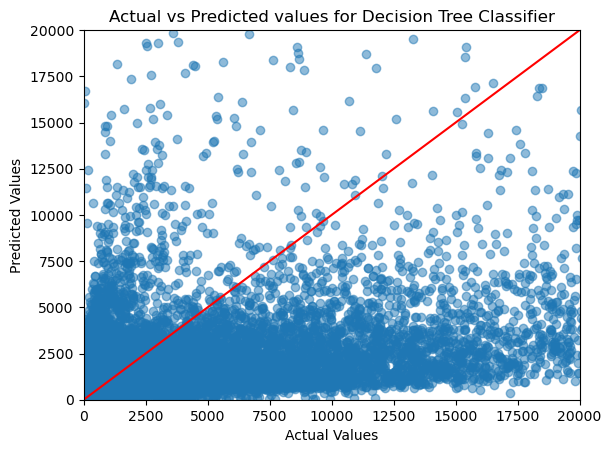

In [26]:
min_axis_value = 0  
max_axis_value = 20000  

# Create the scatter plot
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted values for Decision Tree Classifier')

plt.plot([min_axis_value, max_axis_value], [min_axis_value, max_axis_value], 'r')  # Diagonal line

# Set the limits for x and y axes
plt.xlim(min_axis_value, max_axis_value)
plt.ylim(min_axis_value, max_axis_value)

plt.savefig('regression_plot.png',dpi = 300)

plt.show()